In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sqlite3

In [2]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
MINIMUM_NUMBER_OF_RUNS = 3

In [3]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features-backup".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


#### look at e.coli only that appear in more half the runs in the experiment

In [5]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,number_of_runs_extracted,human,run_name,batch,intensity,isotope_idx_not_in_saturation from features where human is false and number_of_runs_extracted >= {} order by intensity desc'.format(MINIMUM_NUMBER_OF_RUNS), db_conn)
db_conn.close()


In [6]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [7]:
sequences_df[['sequence','charge','intensity','file_idx']].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,intensity,file_idx
4524,VNEDLGLLSEEK,2,5889,17
9218,LQTYIDQVEGK,2,2797,6
10250,ENLGSGFISLFR,2,2463,13
12739,GKDQGVVVNNVK,2,1856,11
16035,VEVAGWVEDPDTYPMAAK,2,1327,6
16258,NAALLAEVPHSVPAVTVNR,2,1297,11
18840,GSWLDFEFDPK,2,996,17
20326,IGVM[15.9949]FGNPETTTGGNALK,2,850,5
23696,FVAINFEPVVGEILEK,2,581,5
28100,VNENLDINPTHYLDINHADIVAR,3,285,11


#### analyse a selected sequence across the experiment for runs in which it was classified as a target

In [8]:
selected_sequence = 'FMDDHGFLDIETPMLTK'
selected_sequence_charge = 3

In [9]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

#### compare the intensities across the experiment for the selected sequence

In [10]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

In [11]:
MAX_SUMMED_APEX_POINTS = 3 * 3000

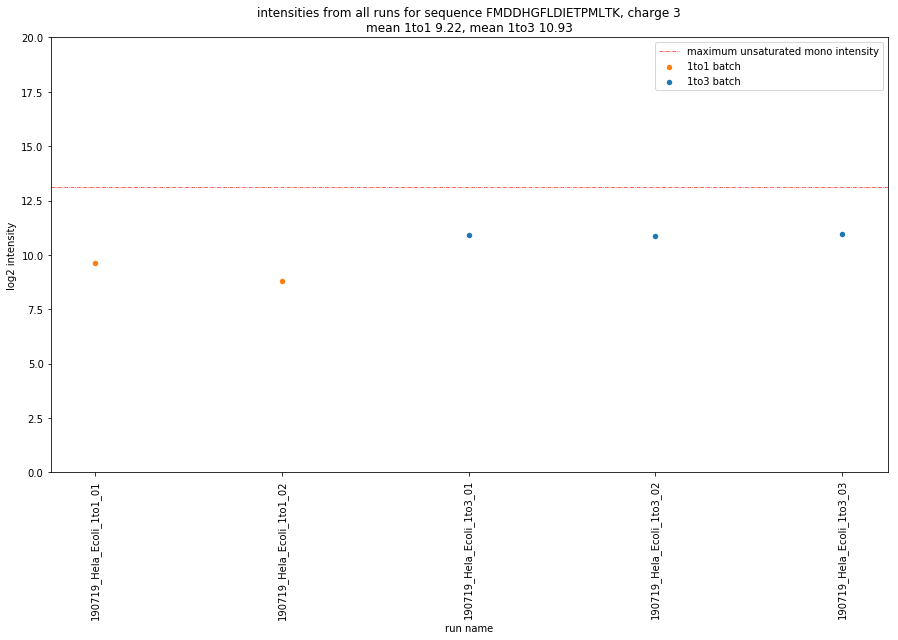

In [12]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity)), 2)

plt.title('intensities from all runs for sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, selected_sequence_1to1_df.log_intensity, marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1 batch')
ax1.scatter(selected_sequence_1to3_df.run_name, selected_sequence_1to3_df.log_intensity, marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3 batch')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to1) > 0:
    ax1.plot(adj_sat_1to1.run_name, adj_sat_1to1.log_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='inferred intensity')

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to3) > 0:
    ax1.plot(adj_sat_1to3.run_name, adj_sat_1to3.log_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='_nolegend_')

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, row.log_intensity+2.1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, row.log_intensity+2.1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)

plt.axhline(y=np.log2(MAX_SUMMED_APEX_POINTS), color='red', linestyle='-.', linewidth=0.6, label='maximum unsaturated mono intensity')

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of e.coli intensity deltas for sequences in 1to1 runs 01 and 02

In [13]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [14]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [15]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

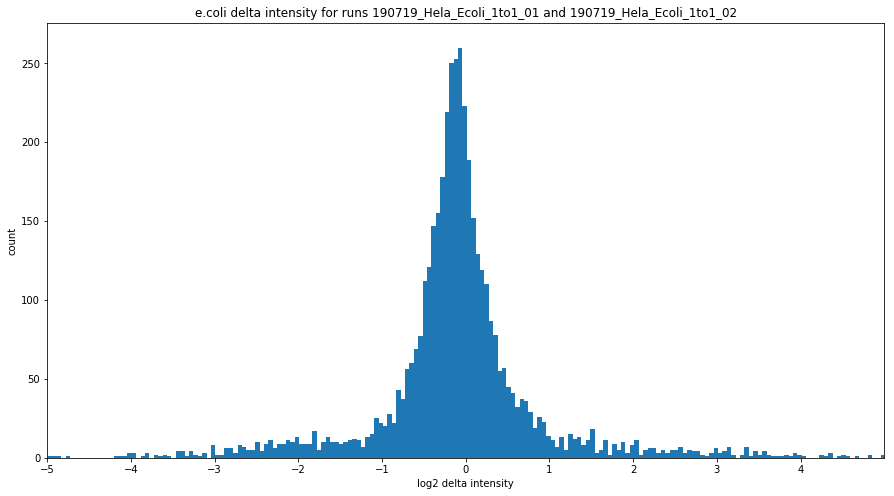

In [16]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('e.coli delta intensity for runs {} and {}'.format(run_A, run_B))
ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [17]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_extracted >= MINIMUM_NUMBER_OF_RUNS)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_medians_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.batch.unique()) == 2:
        batch_1to1_median = group_df[group_df.batch == '1to1'].intensity.median()
        batch_1to3_median = group_df[group_df.batch == '1to3'].intensity.median()
        batch_medians_l.append((group_name[0], group_name[1], batch_1to1_median, batch_1to3_median))
batch_medians_df = pd.DataFrame(batch_medians_l, columns=['sequence','charge','batch_1to1_median','batch_1to3_median'])
batch_medians_df['log_batch_1to1_median'] = np.log2(batch_medians_df.batch_1to1_median)
batch_medians_df['log_batch_1to3_median'] = np.log2(batch_medians_df.batch_1to3_median)
batch_medians_df['delta_log_median'] = batch_medians_df.log_batch_1to3_median - batch_medians_df.log_batch_1to1_median

In [18]:
batch_medians_df.sample(n=5)

,sequence,charge,batch_1to1_median,batch_1to3_median,log_batch_1to1_median,log_batch_1to3_median,delta_log_median
3761,Q[-17.0265]LLQELQESFGGPTGEHNSPR,2,371.0,1105.0,8.535275,10.109831,1.574555
2733,KPDAALVDFLCENADVITK,2,402.5,642.0,8.652845,9.326429,0.673585
3514,NQLRDEVDR,2,4886.0,13916.0,12.254438,13.764457,1.510019
4712,VIGITNEEAISTAR,2,5477.0,8715.0,12.419170,13.089285,0.670115
4881,VSSPVSTMMACPDGK,2,616.0,444.0,9.266787,8.794416,-0.472371


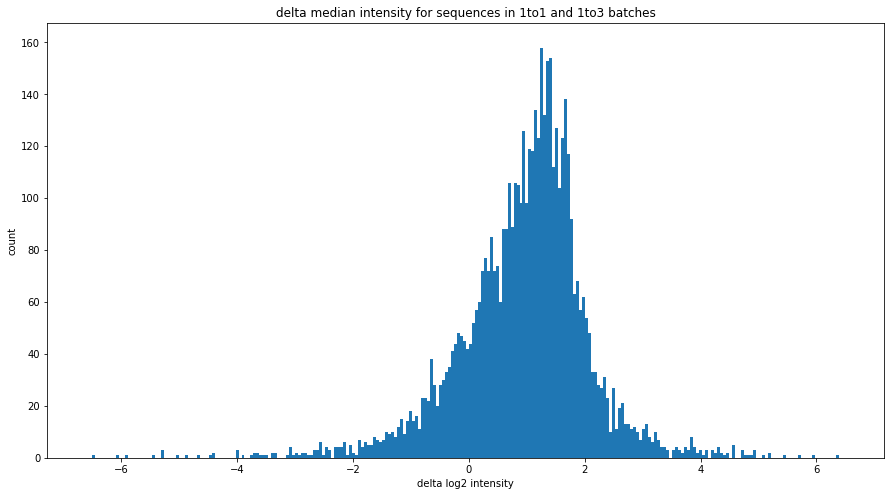

In [19]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_medians_df.delta_log_median, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta median intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [20]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_extracted >= MINIMUM_NUMBER_OF_RUNS)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_means_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.batch.unique()) == 2:
        batch_1to1_mean = group_df[group_df.batch == '1to1'].intensity.mean()
        batch_1to3_mean = group_df[group_df.batch == '1to3'].intensity.mean()
        batch_means_l.append((group_name[0], group_name[1], batch_1to1_mean, batch_1to3_mean))
batch_means_df = pd.DataFrame(batch_means_l, columns=['sequence','charge','batch_1to1_mean','batch_1to3_mean'])
batch_means_df['log_batch_1to1_mean'] = np.log2(batch_means_df.batch_1to1_mean)
batch_means_df['log_batch_1to3_mean'] = np.log2(batch_means_df.batch_1to3_mean)
batch_means_df['delta_log_mean'] = batch_means_df.log_batch_1to3_mean - batch_means_df.log_batch_1to1_mean

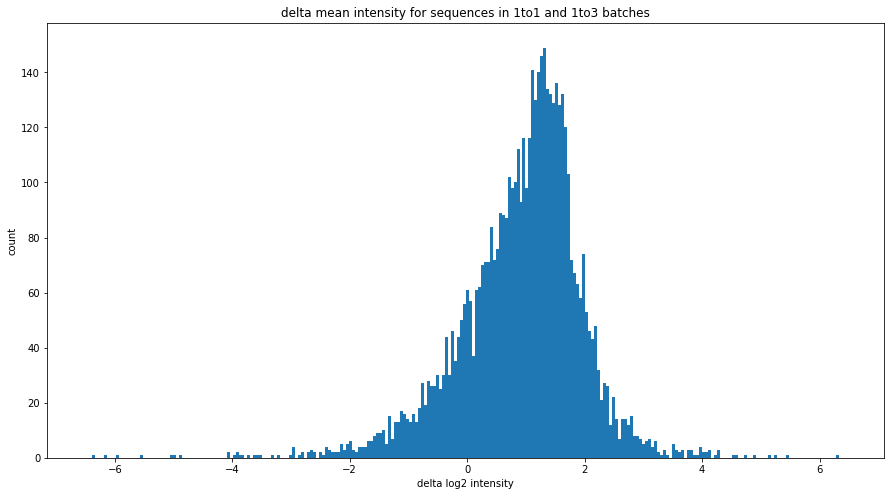

In [21]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_means_df.delta_log_mean, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta mean intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

#### look at all sequences - human and e.coli

In [22]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,number_of_runs_extracted,human,run_name,batch,intensity,isotope_idx_not_in_saturation from features order by intensity desc', db_conn)
db_conn.close()


In [23]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [24]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [25]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [26]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

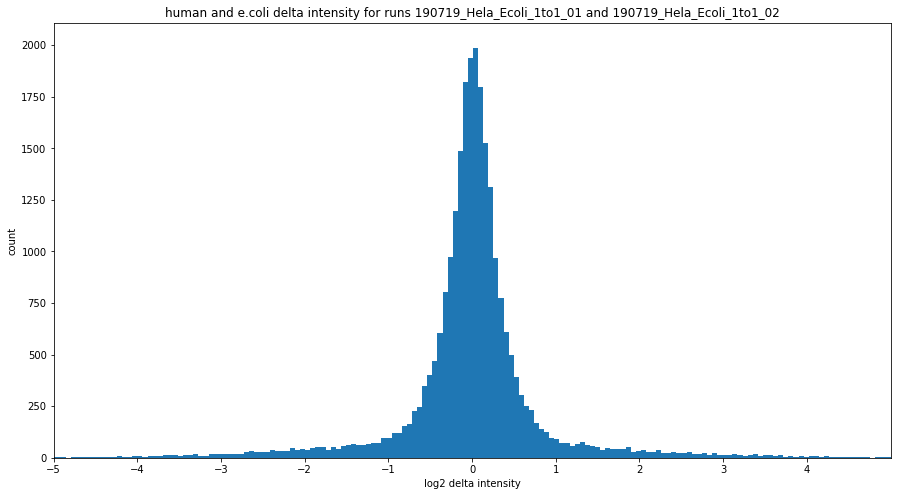

In [27]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('human and e.coli delta intensity for runs {} and {}'.format(run_A, run_B))
ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [28]:
sequences_in_both_runs_df.columns

Index(['sequence', 'charge', 'file_idx_x', 'peak_idx_x',
       'number_of_runs_extracted_x', 'human_x', 'run_name_x', 'batch_x',
       'intensity_x', 'isotope_idx_not_in_saturation_x', 'log_intensity_x',
       'file_idx_y', 'peak_idx_y', 'number_of_runs_extracted_y', 'human_y',
       'run_name_y', 'batch_y', 'intensity_y',
       'isotope_idx_not_in_saturation_y', 'log_intensity_y',
       'delta_log_intensity'],
      dtype='object')

In [29]:
human_df = sequences_in_both_runs_df[sequences_in_both_runs_df.human_x == True]
ecoli_df = sequences_in_both_runs_df[sequences_in_both_runs_df.human_x == False]

In [42]:
linear_df = pd.DataFrame([(1.5,1.5),(5.5,5.5)], columns=['one_to_one','one_to_three'])

In [43]:
linear_df

,one_to_one,one_to_three
0,1.5,1.5
1,5.5,5.5


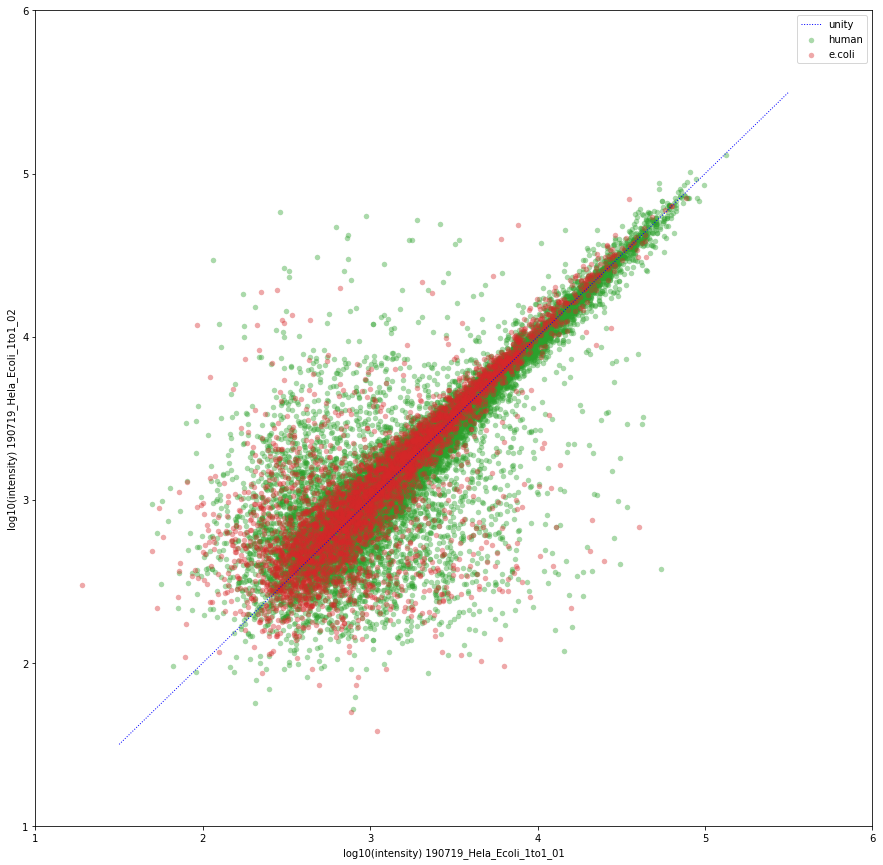

In [44]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

# title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
# plt.title(title)

ax.scatter(np.log10(human_df.intensity_x), np.log10(human_df.intensity_y), marker='o', color='tab:green', lw=0, s=30, alpha=0.4, label='human')
ax.scatter(np.log10(ecoli_df.intensity_x), np.log10(ecoli_df.intensity_y), marker='o', color='tab:red', lw=0, s=30, alpha=0.4, label='e.coli')

ax.plot(linear_df.one_to_one, linear_df.one_to_three, marker='', color='blue', linestyle=':', linewidth=1, ms=5, label='unity')

plt.legend(loc='best')
plt.xlabel('log10(intensity) {}'.format(run_A))
plt.ylabel('log10(intensity) {}'.format(run_B))

plt.xlim((1,6))
plt.ylim((1,6))

plt.show()